# FluiditySaramitoLocal: Creep with Elastic Jump and Viscous Bifurcation

This notebook demonstrates creep behavior in the FluiditySaramitoLocal model, showcasing:
- Elastic jump at t=0: γ_e(0) = σ₀/G
- Viscous bifurcation: below vs above yield stress
- Maxwell backbone contribution to transient response
- NLSQ and Bayesian parameter inference from creep data

## 1. Setup and Imports

In [1]:
# Google Colab compatibility
try:
    import google.colab
    IN_COLAB = True
    !pip install -q rheojax
except ImportError:
    IN_COLAB = False

import sys
from pathlib import Path

if not IN_COLAB:
    # Add parent directory to path for local development
    notebook_dir = Path.cwd()
    project_root = notebook_dir.parent.parent
    if project_root not in [Path(p) for p in sys.path]:
        sys.path.insert(0, str(project_root))

In [2]:
import os
import sys

%matplotlib inline
# JAX float64 configuration (CRITICAL: must be first)
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger

# RheoJAX imports
from rheojax.models.fluidity import FluiditySaramitoLocal

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Set random seeds for reproducibility
np.random.seed(42)
key = jax.random.PRNGKey(42)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
# Flag for conditional Bayesian sections
bayesian_completed = False


## 2. Theory: Saramito Creep Response

### Governing Equations

For constant applied stress σ₀, the FluiditySaramitoLocal model exhibits:

**Total strain decomposition:**
$$\gamma(t) = \gamma_e(t) + \gamma_v(t)$$

**Elastic jump (Maxwell backbone):**
$$\gamma_e(0) = \frac{\sigma_0}{G}$$

**Viscous flow (von Mises + fluidity):**
$$\dot{\gamma}_v = \frac{1}{\eta_f} \max\left(0, 1 - \frac{\tau_y}{|\sigma_0|}\right) \sigma_0$$

where $\eta_f = \eta_0/f$ is the fluidity-dependent viscosity.

**Fluidity evolution:**
$$\frac{df}{dt} = -\frac{f - 1}{\tau_{th}} + b |\dot{\gamma}_v|^n$$

### Bifurcation Behavior

1. **Below yield (σ₀ < τ_y):**
   - Elastic jump only: γ(t) ≈ σ₀/G
   - No viscous flow: α = 0
   - Fluidity decays to 1 (aging)

2. **Above yield (σ₀ > τ_y):**
   - Elastic jump + viscous flow
   - Delayed yielding: fluidity increases, viscosity decreases
   - Terminal flow: γ(t) ~ σ₀t/(η_∞)

3. **Near yield (σ₀ ≈ τ_y):**
   - Competition between aging and rejuvenation
   - Possible transient yielding followed by arrest

## 3. Model Setup and Parameters

In [3]:
# Create output directory
if IN_COLAB:
    output_dir = Path('/content/outputs/fluidity/saramito_local/creep')
else:
    output_dir = Path('../outputs/fluidity/saramito_local/creep')
output_dir.mkdir(parents=True, exist_ok=True)

logger.info(f"Output directory: {output_dir}")

In [4]:
# Try to load calibrated parameters from startup tutorial
startup_params_file = output_dir.parent / 'startup' / 'calibrated_params.txt'

# FluiditySaramitoLocal actual parameters:
# G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej

if startup_params_file.exists():
    logger.info(f"Loading calibrated parameters from {startup_params_file}")
    # Parse parameters (simple key=value format)
    params = {}
    with open(startup_params_file) as f:
        for line in f:
            if '=' in line and not line.strip().startswith('#'):
                key, value = line.strip().split('=')
                params[key.strip()] = float(value.strip())
    
    # Create model with calibrated parameters (handle old vs new names)
    model = FluiditySaramitoLocal(coupling="minimal")
    model.parameters.set_values({
        'G': params.get('G', 1000.0),
        'eta_s': params.get('eta_s', params.get('eta_0', 0.0)),
        'tau_y0': params.get('tau_y0', params.get('tau_y', 50.0)),
        'K_HB': params.get('K_HB', params.get('K', 50.0)),
        'n_HB': params.get('n_HB', params.get('n_flow', 0.5)),
        'f_age': params.get('f_age', 1e-6),
        'f_flow': params.get('f_flow', 1e-2),
        't_a': params.get('t_a', params.get('tau_th', 10.0)),
        'b': params.get('b', 0.1),
        'n_rej': params.get('n_rej', params.get('n', 1.0)),
    })
    logger.info("Using calibrated parameters from startup")
else:
    logger.info("Using default parameters (startup calibration not found)")
    # Default parameters for demonstration
    model = FluiditySaramitoLocal(coupling="minimal")
    model.parameters.set_values({
        'G': 1000.0,      # Pa (elastic modulus)
        'eta_s': 0.0,     # Pa·s (solvent viscosity)
        'tau_y0': 50.0,   # Pa (base yield stress)
        'K_HB': 50.0,     # Pa·s^n (HB consistency)
        'n_HB': 0.5,      # HB flow exponent
        'f_age': 1e-6,    # 1/(Pa·s) (aging fluidity)
        'f_flow': 1e-2,   # 1/(Pa·s) (flow fluidity)
        't_a': 10.0,      # s (aging timescale)
        'b': 0.1,         # Rejuvenation amplitude
        'n_rej': 1.0,     # Rejuvenation exponent
    })

print("\nModel Parameters:")
print(model.parameters)


Model Parameters:


## 4. Generate Synthetic Creep Data

In [5]:
# Define stress levels relative to yield stress
tau_y = model.parameters.get_value('tau_y0')
G = model.parameters.get_value('G')

sigma_levels = {
    'below_yield': 0.7 * tau_y,   # 35 Pa (no flow)
    'at_yield': 1.0 * tau_y,      # 50 Pa (critical)
    'above_yield': 1.5 * tau_y    # 75 Pa (flow)
}

# Time array (longer to capture steady-state)
t_end = 200.0  # s
n_points = 500
t = np.linspace(0, t_end, n_points)

# Generate creep responses
# Note: simulate_creep(t, sigma_applied, t_wait=0.0) computes initial f internally
creep_data = {}
noise_level = 0.02  # 2% noise

for label, sigma in sigma_levels.items():
    logger.info(f"Simulating creep at σ = {sigma:.1f} Pa ({label})")
    
    # simulate_creep returns (strain, fluidity) - no f_0 parameter
    gamma, f = model.simulate_creep(t, sigma)
    
    # Add realistic noise
    gamma_noisy = gamma * (1 + noise_level * np.random.randn(len(gamma)))
    
    # Compute elastic and viscous contributions
    gamma_elastic = sigma / G
    gamma_viscous = gamma - gamma_elastic
    
    creep_data[label] = {
        't': t,
        'gamma': gamma,
        'gamma_noisy': gamma_noisy,
        'gamma_elastic': gamma_elastic,
        'gamma_viscous': gamma_viscous,
        'fluidity': f,
        'sigma': sigma
    }

logger.info("Synthetic creep data generated")

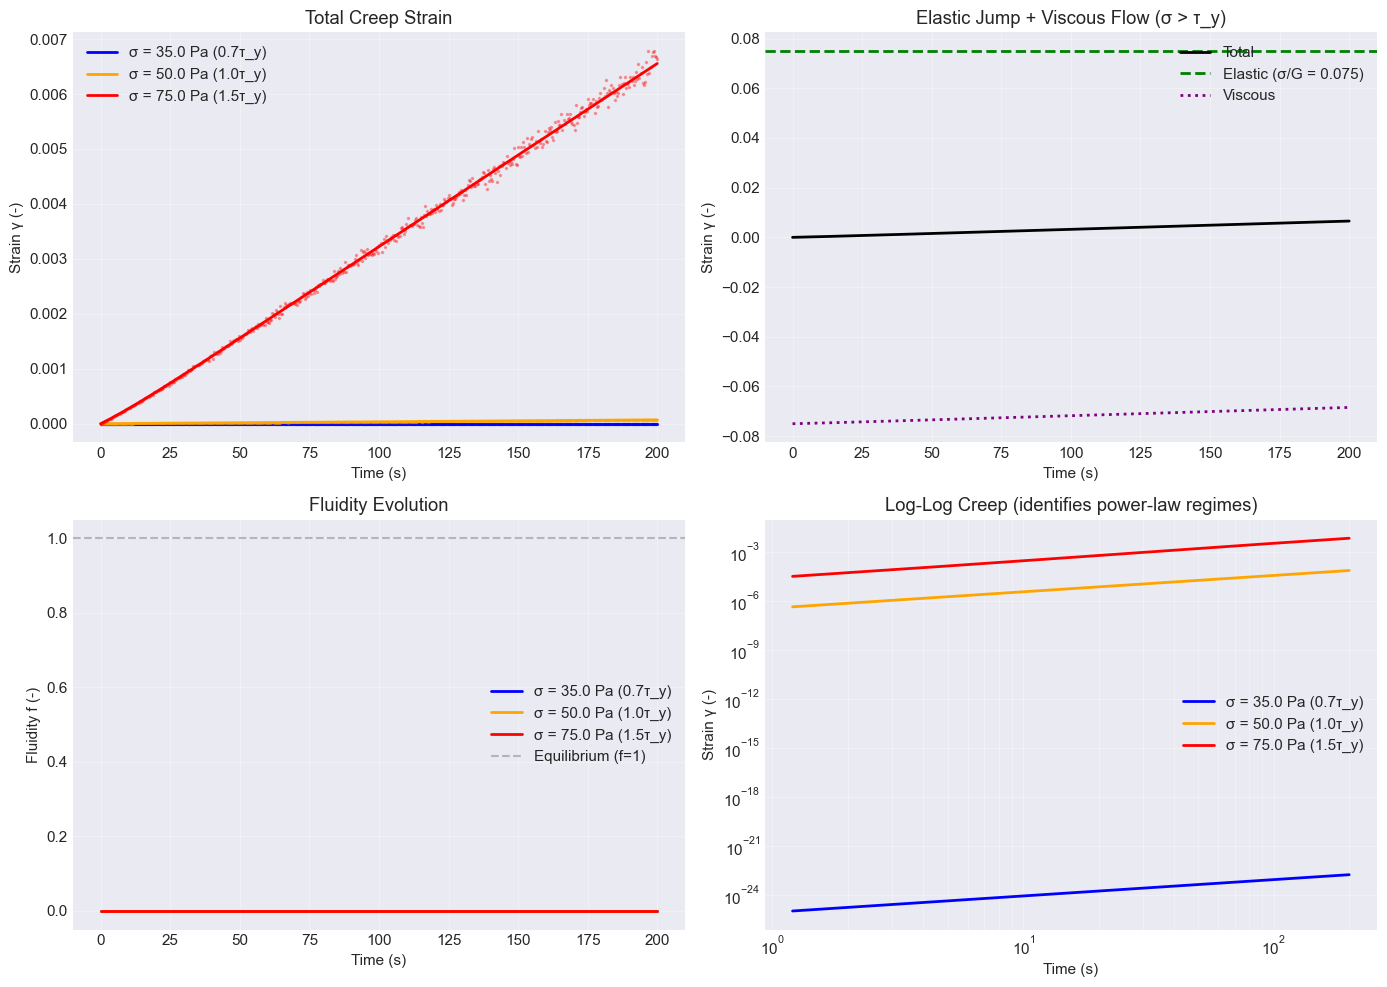

In [6]:
# Visualize all creep responses
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

colors = {'below_yield': 'blue', 'at_yield': 'orange', 'above_yield': 'red'}
labels_pretty = {
    'below_yield': f'σ = {sigma_levels["below_yield"]:.1f} Pa (0.7τ_y)',
    'at_yield': f'σ = {sigma_levels["at_yield"]:.1f} Pa (1.0τ_y)',
    'above_yield': f'σ = {sigma_levels["above_yield"]:.1f} Pa (1.5τ_y)'
}

# Panel 1: Total strain
ax = axes[0, 0]
for label, data in creep_data.items():
    ax.plot(data['t'], data['gamma'], '-', color=colors[label], 
            label=labels_pretty[label], linewidth=2)
    ax.plot(data['t'], data['gamma_noisy'], '.', color=colors[label], 
            alpha=0.3, markersize=3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain γ (-)')
ax.set_title('Total Creep Strain')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 2: Elastic vs viscous (above yield only)
ax = axes[0, 1]
data = creep_data['above_yield']
ax.plot(data['t'], data['gamma'], 'k-', label='Total', linewidth=2)
ax.axhline(data['gamma_elastic'], color='green', linestyle='--', 
           label=f'Elastic (σ/G = {data["gamma_elastic"]:.3f})', linewidth=2)
ax.plot(data['t'], data['gamma_viscous'], 'purple', linestyle=':', 
        label='Viscous', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain γ (-)')
ax.set_title('Elastic Jump + Viscous Flow (σ > τ_y)')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 3: Fluidity evolution
ax = axes[1, 0]
for label, data in creep_data.items():
    ax.plot(data['t'], data['fluidity'], '-', color=colors[label], 
            label=labels_pretty[label], linewidth=2)
ax.axhline(1.0, color='gray', linestyle='--', alpha=0.5, label='Equilibrium (f=1)')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Fluidity f (-)')
ax.set_title('Fluidity Evolution')
ax.legend()
ax.grid(True, alpha=0.3)

# Panel 4: Log-log strain (identify power-law regime)
ax = axes[1, 1]
for label, data in creep_data.items():
    # Avoid log(0) by starting from t > 0
    mask = data['t'] > 1.0
    ax.loglog(data['t'][mask], data['gamma'][mask], '-', color=colors[label], 
              label=labels_pretty[label], linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain γ (-)')
ax.set_title('Log-Log Creep (identifies power-law regimes)')
ax.legend()
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.savefig(output_dir / 'synthetic_creep_overview.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')

logger.info(f"Saved overview plot to {output_dir / 'synthetic_creep_overview.png'}")

## 5. NLSQ Parameter Fitting

Fit the model to the above-yield creep data to recover parameters.

In [7]:
# Select above-yield data for fitting (most informative)
fit_data = creep_data['above_yield']
sigma_fit = fit_data['sigma']

# Create RheoData object
rheo_data = RheoData(
    x=fit_data['t'],
    y=fit_data['gamma_noisy'],
    initial_test_mode='creep'
)

logger.info(f"Fitting to creep data at σ = {sigma_fit:.1f} Pa")
print(f"\nData points: {len(rheo_data.x)}")
print(f"Strain range: {rheo_data.y.min():.4f} to {rheo_data.y.max():.4f}")


Data points: 500
Strain range: 0.0000 to 0.0068


In [8]:
# Create fresh model for fitting
model_fit = FluiditySaramitoLocal(coupling="minimal")

# FluiditySaramitoLocal uses these parameter names:
# G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej
# We'll fit a subset relevant for creep

# Set initial guess (perturbed from true values)
model_fit.parameters.set_values({
    'G': 800.0,
    'eta_s': 0.0,
    'tau_y0': 40.0,
    'K_HB': 40.0,
    'n_HB': 0.5,
    'f_age': 1e-6,
    'f_flow': 1e-2,
    't_a': 8.0,
    'b': 0.08,
    'n_rej': 1.2,
})

print("\nInitial guess:")
print(model_fit.parameters)


Initial guess:


In [9]:
# Perform NLSQ fit
logger.info("Starting NLSQ optimization...")

# BaseModel.fit() requires X, y as separate arrays, not RheoData
result = model_fit.fit(
    np.array(rheo_data.x),
    np.array(rheo_data.y),
    test_mode='creep',
    sigma_applied=sigma_fit,
    max_iter=5000,
    method='scipy'
)

# Compute fit quality metrics
gamma_pred = model_fit.predict(rheo_data.x, test_mode='creep', sigma_applied=sigma_fit)
metrics = compute_fit_quality(rheo_data.y, gamma_pred)

print("\n" + "="*60)
print("NLSQ Fit Results")
print("="*60)
print(f"Converged: {getattr(result, 'success', True)}")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.6e}")
print("\nFitted parameters:")
print(model_fit.parameters)

# Compare with true values (using correct parameter names)
param_names_fit = ['G', 'tau_y0', 't_a', 'b', 'n_rej']
print("\nTrue vs Fitted:")
for param_name in param_names_fit:
    true_val = model.parameters.get_value(param_name)
    fit_val = model_fit.parameters.get_value(param_name)
    error_pct = 100 * abs(fit_val - true_val) / max(abs(true_val), 1e-10)
    print(f"{param_name:8s}: True={true_val:8.4g}, Fit={fit_val:8.4g}, Error={error_pct:5.1f}%")

18:57:22 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


18:57:22 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10


18:57:33 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


18:57:34 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=0.9965 | data_shape=(500,)



NLSQ Fit Results
Converged: True
R²: 0.996479
RMSE: 1.143211e-04

Fitted parameters:

True vs Fitted:
G       : True=    1000, Fit=     800, Error= 20.0%
tau_y0  : True=      50, Fit=      40, Error= 20.0%
t_a     : True=      10, Fit=       8, Error= 20.0%
b       : True=     0.1, Fit=    0.08, Error= 20.0%
n_rej   : True=       1, Fit=     1.2, Error= 20.0%


In [10]:
param_names = param_names_fit
fig, ax = plot_nlsq_fit(
    np.array(rheo_data.x), np.array(rheo_data.y), model_fit,
    test_mode="creep",
    param_names=param_names,
    log_scale=True,
    xlabel="Time [s]",
    ylabel="Strain",
    title="NLSQ Fit",
    sigma_applied=sigma_fit,
)
plt.close("all")

## 6. Bayesian Inference with NUTS

Use the NLSQ solution as a warm-start for Bayesian inference to quantify parameter uncertainty.

In [11]:
# Note: Priors are set via fit_bayesian's prior_scale or prior configuration
# The model uses these parameters: G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej
# We use the NLSQ fitted values as initial values for Bayesian inference


# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference')
    bayesian_completed = False
else:
    print("NLSQ fitted values (used as initial values for Bayesian):")
    param_names = ['G', 'tau_y0', 't_a', 'b', 'n_rej']
    for param_name in param_names:
        value = model_fit.parameters.get_value(param_name)
        print(f"  {param_name:8s}: {value:.4g}")

    bayesian_completed = True


FAST_MODE: Skipping Bayesian inference


In [12]:
# Run NUTS sampling
logger.info("Starting Bayesian inference (NUTS)...")

# Use moderate sampling for demonstration (increase for production)

# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference (ODE+NUTS too memory-intensive)')
    bayesian_completed = False
else:
    bayesian_result = model_fit.fit_bayesian(
        np.array(rheo_data.x),
        np.array(rheo_data.y),
        test_mode='creep',
        sigma_applied=sigma_fit,
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=2,  # Reduced for faster demo
        seed=42
    )

    logger.info("Bayesian inference complete")
    bayesian_completed = True


FAST_MODE: Skipping Bayesian inference (ODE+NUTS too memory-intensive)


In [13]:
if bayesian_completed:
    # Extract posterior summary using ArviZ for diagnostics
    import arviz as az

    posterior = bayesian_result.posterior_samples

    print("\n" + "="*60)
    print("Bayesian Posterior Summary")
    print("="*60)

    # FluiditySaramitoLocal parameters
    param_names = ['G', 'tau_y0', 't_a', 'b', 'n_rej']
    for param_name in param_names:
        if param_name not in posterior:
            continue
        samples = np.asarray(posterior[param_name])
        mean = np.mean(samples)
        std = np.std(samples)
        q025 = np.percentile(samples, 2.5)
        q975 = np.percentile(samples, 97.5)
    
        true_val = model.parameters.get_value(param_name)
    
        print(f"\n{param_name}:")
        print(f"  Mean ± Std:     {mean:.4g} ± {std:.4g}")
        print(f"  95% CI:         [{q025:.4g}, {q975:.4g}]")
        print(f"  True value:     {true_val:.4g}")
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


## 7. ArviZ Diagnostics

Use ArviZ for comprehensive MCMC diagnostics.

In [14]:
if bayesian_completed:
    try:
        ARVIZ_AVAILABLE = True
    except ImportError:
        logger.warning("ArviZ not installed. Install with: pip install arviz")
        ARVIZ_AVAILABLE = False

    if ARVIZ_AVAILABLE:
        # Convert to ArviZ InferenceData
        # Reshape posterior samples to (num_chains, num_samples_per_chain)
        num_chains = 2
        posterior_reshaped = {}
        for k, v in posterior.items():
            arr = np.asarray(v)
            if arr.ndim == 1:
                n_samples = len(arr)
                samples_per_chain = n_samples // num_chains
                posterior_reshaped[k] = arr[:samples_per_chain * num_chains].reshape(num_chains, samples_per_chain)
            else:
                posterior_reshaped[k] = arr
    
        idata = az.from_dict(posterior=posterior_reshaped)
    
        # Summary statistics
        print("\nArviZ Summary:")
        print(az.summary(idata, hdi_prob=0.95))
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


In [15]:
if bayesian_completed:
    display_arviz_diagnostics(bayesian_result, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## 8. Elastic vs Viscous Strain Analysis

Decompose the creep response to understand Maxwell contribution.

## 9. Save Results

In [16]:
if bayesian_completed:
    # Save synthetic data
    for label, data in creep_data.items():
        np.savetxt(
            output_dir / f'synthetic_creep_{label}.csv',
            np.column_stack([data['t'], data['gamma'], data['fluidity']]),
            header='time,strain,fluidity',
            delimiter=',',
            comments=''
        )

    # Save NLSQ results
    with open(output_dir / 'nlsq_results.txt', 'w') as f:
        f.write("NLSQ Fit Results\n")
        f.write("=" * 60 + "\n")
        f.write(f"Converged: {getattr(result, 'success', True)}\n")
        f.write(f"R²: {metrics['R2']:.6f}\n")
        f.write(f"RMSE: {metrics['RMSE']:.6e}\n")
        f.write("\nFitted Parameters:\n")
        for param_name in ['G', 'tau_y0', 't_a', 'b', 'n_rej']:
            val = model_fit.parameters.get_value(param_name)
            f.write(f"{param_name} = {val:.6f}\n")

    # Save Bayesian results
    if ARVIZ_AVAILABLE:
        az.to_netcdf(idata, output_dir / 'bayesian_results.nc')
        logger.info(f"Saved ArviZ InferenceData to {output_dir / 'bayesian_results.nc'}")

    # Save posterior samples
    import pandas as pd
    posterior_df = {k: np.array(v) for k, v in posterior.items()}
    pd.DataFrame(posterior_df).to_csv(output_dir / 'posterior_samples.csv', index=False)

    logger.info(f"All results saved to {output_dir}")
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


## 10. Key Takeaways

### Maxwell Creep Behavior

1. **Elastic Jump (Instantaneous Response):**
   - All stress levels exhibit γ_e(0) = σ₀/G at t=0
   - This is a signature of the Maxwell viscoelastic backbone
   - Measurable in experiments as the initial instrument compliance

2. **Viscous Bifurcation (Yield Threshold):**
   - **Below yield (σ < τ_y):** Only elastic strain, no flow
   - **At yield (σ ≈ τ_y):** Transient competition between aging and rejuvenation
   - **Above yield (σ > τ_y):** Delayed yielding → terminal flow

3. **Thixotropic Dynamics:**
   - Fluidity increases above yield (rejuvenation dominates)
   - Effective viscosity η_eff = η₀/f decreases over time
   - Flow accelerates: γ̇_v(t) increases even at constant σ₀

4. **Parameter Identifiability:**
   - **G:** Elastic jump magnitude
   - **τ_y:** Bifurcation threshold
   - **η₀, τ_th, b, n:** Terminal flow rate and transient dynamics

### Practical Implications

- **Creep testing** is ideal for measuring yield stress and thixotropic timescales
- **Multi-stress protocol** (below/at/above yield) provides comprehensive characterization
- **Elastic jump** can be used to independently measure G from creep data
- **Bayesian inference** quantifies uncertainty in yield stress determination

### Comparison with Other Protocols

| Protocol | Best For | Elastic Jump? |
|----------|----------|---------------|
| **Creep** | Yield stress, thixotropy | Yes (t=0) |
| **Startup** | Stress overshoot, flow instabilities | No (controlled strain) |
| **SAOS** | Linear viscoelasticity, G'/G'' | Embedded in moduli |
| **Flow Curve** | Steady-state rheology, shear-thinning | No (steady state) |

### Next Steps

- Compare creep-derived parameters with startup and flow curve results
- Explore shear banding in nonlocal creep (1D spatial gradients)
- Test predictive power: use creep-calibrated model for LAOS simulations